# Making nest egg calculator

The nest can calculator is being made with the US data but can be easily created if the data is replaced for IN stock market, bond market and inflation rate.

### Input Parameters:

- Calculation Parameters

    - Total returns for the S&P 500 (for calculating stock returns)
    - Total returns for 10 year old treasury bills (for calculating bond returns)
    - Rate of three months Tresury bills (for calculating returns with Money in hand)
    - S/B blend ("stock" vs "bond" blend in a 50% ratio)
    - S/B/C blend("stock" vs "bond" vs "Cash" blend in 40-50-10 ratio)
    - Annual inflation rate

- User Parameters

    - Type of investment
    - Starting value of investment (What is the total investment corpus at the start of the retirement period)
    - Yearly withdrawl amount
    - Input for max, min and most likely duration of retirement
    - The number of cases to run
    
### Program Structure

    - Input
        - Mentioned above
        
    - Output
        - the final investment amount after specific number of years or getting bankrupt (which ever is the possible explaination)
    
    - Process
        - asking the user to choose input variables
        - referring the investment type and starting value of the investment that the user has chosen in the calculation
        - Running Monte-Carlo simulation
            - maintain two lists (Final result and bankrupt to capture the two individual scenarios)
            - For each of the number of simulations:
                - randomly determine the start year of the simulation
                - randomly determine the duration of the retirement(time period before death)
                - duration of the life time can be calculated by adding the duration to the start year
                - randomly determine the duration of the retirement using random.triangulation
                - as per the duration of the retirement determine the inflation
                - the distribution of the period, will correspond to the randomly selected period in:
                    - the investment type data (for bonds as a inflation type, use the 10-yr bond data and so on)
                    - the inflation data
                - From the starting value of investment, deduct the monthly takeout
                - For the remaining amount, deduct/add the investment return
                - For the remaining amount, deduct/add the inflation (this amount will be used to calculate the result for the next year)
                - This loop to be repeated untill the end of the said period or if the case went bankrupt
            - Repeat the above for the number of simulations defined


In [46]:
import random
import matplotlib.pyplot as plt

In [47]:
def read_from_file(file_name):
    """read from the text file, convert the % to decimal and return a list"""
    with open(file_name) as file:
        lines = [float(line.strip()) for line in file] # removing whitespace
        data = [round(line / 100, 5) for line in lines] # converting % to decimal numbers
        return data

In [75]:
def default_input(prompt, default = None):
    """capture the user inputs, returns prompt or default if prompt is None"""
    info = f"{prompt} [{default}]"
    response = input(prompt)
    if not response and default:
        return default
    else:
        return response


## Loading the data

In [49]:
# Note: All the input data should be in "%" only
# Note 2: All the conversion would be done in the input function only
bonds = read_from_file('10-yr_TBond_returns_1926-2013_pct.txt')
stocks = read_from_file('SP500_returns_1926-2013_pct.txt')
blend_50_50 = read_from_file('S-B_blend_1926-2013_pct.txt')
blend_40_50_10 = read_from_file('S-B-C_blend_1926-2013_pct.txt')
cash = read_from_file('3_mo_TBill_rate_1926-2013_pct.txt')
inflation = read_from_file('annual_infl_rate_1926-2013_pct.txt')


## Loading and validating the User data

In [50]:
investment_type_args = {'bonds': bonds, 'stocks': stocks, 'sb_blend': blend_50_50, 'sbc_blend':blend_40_50_10}

# user support legends

print(" bonds = 10 Year treasury Bonds")
print(" stocks = SP 500")
print(" sb_blend = 50% stocks and 50% Bonds")
print(" sbc_blend = 40% stocks, 50% bonds and 10% cash")

print("\n Please enter the value of the investments or accept the default value!")


 bonds = 10 Year treasury Bonds
 stocks = SP 500
 sb_blend = 50% stocks and 50% Bonds
 sbc_blend = 40% stocks, 50% bonds and 10% cash

 Please enter the value of the investments or accept the default value!


In [101]:
# entering the value of bonds

investment_type = default_input("Please enter the type of investment you wish to make \n(options: bonds, stocks, sb_blend and sbc_blend)\n", 'bonds').lower()

Please enter the type of investment you wish to make 
(options: bonds, stocks, sb_blend and sbc_blend)
 stocks


In [102]:
start_value = default_input("Please enter the starting investment value.\n",2000000)

Please enter the starting investment value.
 50000000


In [103]:
withdrawl = default_input("Please enter the Yearly withdrawl amount.\n", 1000000)

Please enter the Yearly withdrawl amount.
 1000000


In [104]:
min_years = default_input("Please enter the mininum years of retirement.\n", 10)

Please enter the mininum years of retirement.
 20


In [105]:
most_likely_years = default_input("Please enter the most likely years of retirement.\n", 15)

Please enter the most likely years of retirement.
 25


In [106]:
max_years = default_input("Please enter the max years of retirement.\n", 20)

Please enter the max years of retirement.
 30


In [115]:
num_cases = default_input("Please enter the simulation count.\n", 50000)

Please enter the simulation count.
 10


## Running Monte-Carlo simulation

In [150]:
def montecarlo(returns):
    """runs monte carlo simulation and returns end of the year investment amount and/or bankruptcy count"""
    case_count = 0
    bankrupt_count = 0
    outcome = []
    
    while case_count < int(num_cases):
        investments = int(start_value)
        start_year =  random.randrange(0, len(returns))
        duration = int(random.triangular(int(min_years), int(max_years), int(most_likely_years)))
        end_year = start_year + duration
        
        lifespan = [i for i in range(start_year, end_year)]
        print(lifespan)
        bankrupt = "no"
        
        # building temporary list to capture the information
        lifespan_returns = []
        lifespan_infl = []
        for i in lifespan:         # builds the inflation and return % on randomly selected start year and duration
            lifespan_returns.append(returns[i % len(returns)])
            lifespan_infl.append(inflation[i % len(inflation)])
        print(lifespan_returns)
        print(lifespan_infl)
        # looping through each year of retirement and deducting inflation adjusted withdrawl amount from the investments
        
        for index, i in enumerate(lifespan_returns):
            infl = lifespan_infl[index]

            if index == 0:
                withdrawl_infl_adjusted = int(withdrawl)
            else:
                withdrawl_infl_adjusted = (int(withdrawl_infl_adjusted) * (1 + infl))

            investments -= withdrawl_infl_adjusted
            investments = int(investments * (1 + i))

            if investments <= 0:
                bankrupt = "yes"
                break

        if bankrupt == "yes":
            outcome.append(0)
            bankrupt_count += 1
        else:
            outcome.append(investments)
        
        case_count += 1
    
    return outcome, bankrupt_count 
        
        
        

In [151]:
# calculating the probablity of ruin

def bankrupt_probablity(outcome, bankrupt_count):
    total_count = len(outcome)
    probablity_ruin = int((bankrupt_count / total_count) * 100)
    
    # printing all the related details
    
    print(f"\n Investment Type: {investment_type}")
    print(f"\n Starting Value: ${start_value}")
    print(f"\n Annual Withdrawl: ${withdrawl}")
    print(f"\n Probable years in retirement, max years: {max_years}, min years: {min_years} and most likely years: {most_likely_years}")
    print(f"\n Number of runs: {num_cases}")
    print(f"\n Odds of money run out: {probablity_ruin}%")
    print(f"\n Average outcome: ${sum(outcome) / len(outcome) }")
    print(f"\n Maximum outcome: ${max(outcome)}")
    print(f"\n Minimum outcome: ${min(outcome)}")
    
    return probablity_ruin

In [152]:
outcome, bankrupt_count = montecarlo(investment_type_args[investment_type])
odds = bankrupt_probablity(outcome, bankrupt_count)

[39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[0.124, -0.1, 0.238, 0.108, -0.082, 0.036, 0.142, 0.188, -0.143, -0.259, 0.37, 0.238, -0.07, 0.065, 0.185, 0.317, -0.047, 0.204, 0.223, 0.061, 0.312]
[0.0159, 0.0301, 0.0278, 0.0427, 0.0546, 0.0584, 0.043, 0.0327, 0.0616, 0.1103, 0.092, 0.0575, 0.065, 0.0762, 0.1122, 0.1358, 0.1035, 0.0616, 0.0322, 0.043, 0.0355]
[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
[0.293, -0.011, -0.107, -0.128, 0.192, 0.251, 0.19, 0.358, -0.084, 0.052, 0.057, 0.183, 0.308, 0.237, 0.182, -0.012, 0.526, 0.326, 0.074, -0.104, 0.437, 0.12, 0.003, 0.266, -0.088, 0.226, 0.164]
[-0.0201, -0.013, 0.0073, 0.0511, 0.1097, 0.06, 0.0164, 0.0227, 0.0843, 0.1465, 0.0774, -0.0095, 0.0109, 0.0788, 0.0229, 0.0082, 0.0032, -0.0028, 0.0152, 0.0334, 0.0273, 0.0101, 0.0146, 0.0107, 0.012, 0.0124, 0.0128]
[64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83

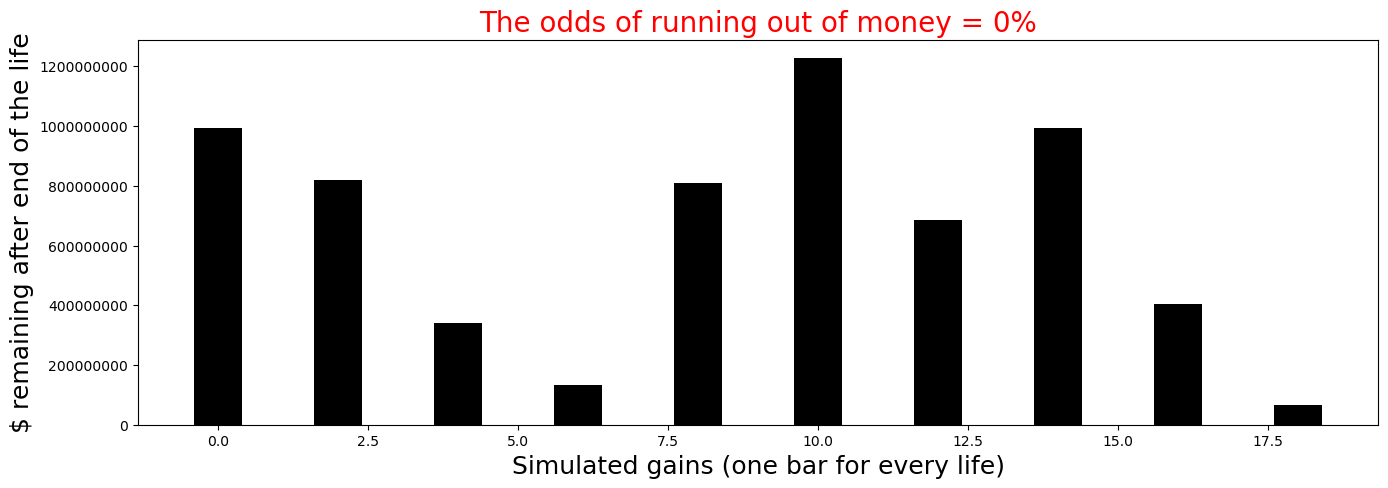

In [147]:
# plotting the barchart

plotdata =  outcome[:3000]

plt.figure(f'Outcome by {len(plotdata)} individual cases', figsize = (16,5))
index = [i+i for i in range(len(plotdata))]
plt.bar(index, plotdata, color = "black")
plt.xlabel("Simulated gains (one bar for every life)", fontsize =18)
plt.ylabel("$ remaining after end of the life", fontsize =18)
plt.ticklabel_format(style = 'plain', axis ='y')

#ax = plt.gca()
#ax.get_yaxis().set_major_formatter(pls.FuncFormatter(lambda x, loc: f"{:,int(x)}"))

plt.title(f"The odds of running out of money = {odds}%", fontsize = 20, color = 'red')
plt.show()
           

In [149]:
outcome

[993520390,
 818293310,
 342040006,
 134497768,
 809619961,
 1227585045,
 684661616,
 993520390,
 404604077,
 65027712]